Removed potentially corrupted existing file: bone_marrow.h5ad
Download complete.
AnnData object with n_obs × n_vars = 14783 × 17374
    obs: 'disease stage', 'treatment', 'timepoint', 'Dataset', 'sample', 'disease_original', 'disease_general', 'COVID-19 Condition', 'Lineage', 'Cell.group', 'Cell.class_reannotated', 'n_genes', 'n_counts', 'percent_mito', 'tissue_original', 'tissue_ontology_term_id', 'disease_ontology_term_id', 'donor_id', 'development_stage_ontology_term_id', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'suspension_type', 'tissue_type', 'assay', 'disease', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'n_cells', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type'
    uns: 'citation', 'doi', 'organism', 'organism_ontology_term_id', 'schema_reference', 'schema_version'

/usr/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


computing PCA
    with n_comps=50
    finished (0:00:19)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:27)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:12)
running Leiden clustering


/tmp/ipython-input-2449689166.py:101: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.5)


    finished: found 10 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:05)


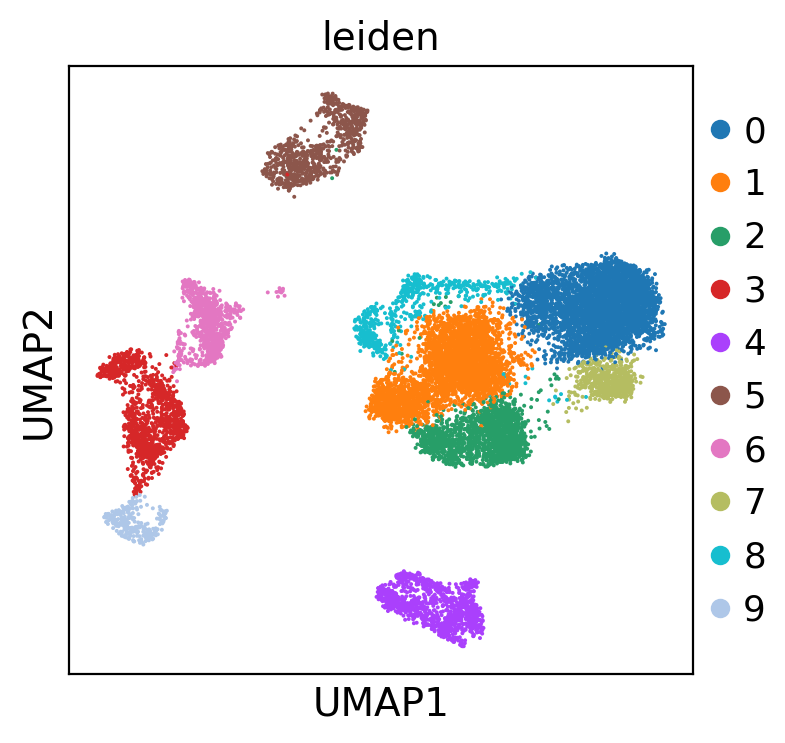

Downloaded Ensembl mapping.

Corrected PanglaoDB markers (head):
          source           target
0    Hepatocytes  ENSG00000148584
2  Bergmann glia  ENSG00000175899
4     Mast cells  ENSG00000128274
6   Interneurons  ENSG00000115977
7        Neurons  ENSG00000115977

Saved processed dataset as bone_marrow_processed.h5ad


In [1]:
# ============================================
# Single-Cell RNA-Seq Analysis Pipeline
# Using Scanpy + Decoupler
# Dataset: Bone Marrow (CZI modified dataset)
# Author: Micaiah Adedeji Adeoluwa
# ============================================

import os
import urllib.request
import urllib.parse
import pandas as pd

# ----------------------------
# Install required packages
# ----------------------------
try:
    import scanpy as sc
except ImportError:
    !pip install scanpy
    import scanpy as sc

try:
    import decoupler as dc
except ImportError:
    !pip install --upgrade --force-reinstall decoupler
    import decoupler as dc

try:
    import igraph
except ImportError:
    !pip install python-igraph

try:
    import leidenalg
except ImportError:
    !pip install leidenalg

# Scanpy display settings
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=100, facecolor="white")


# ============================================
# 1. Download dataset
# ============================================

url = "https://github.com/josoga2/sc/raw/refs/heads/main/bone_marrow.h5ad"
out_file = "bone_marrow.h5ad"

# Ensure clean download: remove existing file if it's incomplete or corrupted
if os.path.exists(out_file):
    os.remove(out_file)
    print(f"Removed potentially corrupted existing file: {out_file}")

print("Downloading dataset...")
urllib.request.urlretrieve(url, out_file)
print("Download complete.")

# Load dataset
adata = sc.read_h5ad(out_file)
print(adata)


# ============================================
# 2. Basic QC + Preprocessing
# ============================================

# Filter low-quality cells and rare genes
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

# Compute mitochondrial percentage if available
if any(adata.var_names.str.startswith("MT-")):
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, inplace=True)

    # Standard QC thresholds for human marrow
    adata = adata[adata.obs.n_genes_by_counts < 5000, :]
    adata = adata[adata.obs.pct_counts_mt < 10, :]

# Normalize → Log transform
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True)

# Scale
sc.pp.scale(adata, max_value=10)


# ============================================
# 3. PCA → Neighbors → UMAP → Leiden
# ============================================

sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

# Cluster using Leiden
sc.tl.leiden(adata, resolution=0.5)

# Save UMAP
sc.pl.umap(adata, color=["leiden"], save="_clusters.png")


# ============================================
# 4. FIXED — Ensembl ↔ Gene Symbol Mapping
# (the original biomart query had an error)
# ============================================

biomart_query = (
    "<?xml version=\"1.0\" encoding=\"UTF-8\"?>"
    "<!DOCTYPE Query>"
    "<Query virtualSchemaName=\"default\" formatter=\"CSV\" header=\"0\" uniqueRows=\"0\" count=\"\" datasetConfigVersion=\"0.6\">"
    "<Dataset name=\"hsapiens_gene_ensembl\" interface=\"default\">"
    "<Attribute name=\"ensembl_gene_id\"/>"
    "<Attribute name=\"external_gene_name\"/>"
    "</Dataset>"
    "</Query>"
)

biomart_url = "http://www.ensembl.org/biomart/martservice?query=" + urllib.parse.quote(biomart_query)
mapping_file = "ensembl_mapping.txt"

if not os.path.exists(mapping_file):
    urllib.request.urlretrieve(biomart_url, mapping_file)
    print("Downloaded Ensembl mapping.")

ensembl_var = pd.read_csv(mapping_file, header=None)
ensembl_var.columns = ["ensembl_gene_id", "gene_name"]


# ============================================
# 5. FIXED — Marker Preparation from PanglaoDB
# ============================================

markers = dc.op.resource(name="PanglaoDB", organism="human")

# Remove duplicates
markers = markers[~markers.duplicated(["cell_type", "genesymbol"])]

# Standardize column names
markers = markers.rename(columns={"cell_type": "source", "genesymbol": "target"})
markers = markers[["source", "target"]]

# Map gene symbols → Ensembl IDs
markers = markers.merge(
    ensembl_var,
    left_on="target",
    right_on="gene_name",
    how="left"
)

markers = markers.drop(columns=["target", "gene_name"])

# Remove duplicates and missing matches
markers = markers.dropna()
markers = markers[~markers.duplicated(["source", "ensembl_gene_id"])]

markers = markers.rename(columns={"ensembl_gene_id": "target"})
markers = markers[["source", "target"]]

print("\nCorrected PanglaoDB markers (head):")
print(markers.head())


# ============================================
# 6. Save processed AnnData
# ============================================

adata.write("bone_marrow_processed.h5ad")
print("\nSaved processed dataset as bone_marrow_processed.h5ad")





In [7]:
#1 Cluster proportions
cluster_counts = adata.obs['leiden'].value_counts().sort_index()
cluster_props = (cluster_counts / cluster_counts.sum()).round(3)
print(cluster_props.to_string())

#2 Top 8 Marker genes per cluster
import numpy as np
sc.tl.rank_genes_groups(adata, groupby='leiden', method='wilcoxon', pts=True)
rg = adata.uns['rank_genes_groups']
groups = rg['names'].dtype.names if isinstance(rg['names'], np.ndarray) else list(rg['names'].dtype.names)
# safe printing for common scanpy versions:
for g in adata.obs['leiden'].cat.categories:
  names = rg['names'][g][:8]
  scores = rg['scores'][g][:8] if 'scores' in rg else ['NA']*len(names)
  print(f"cluster {g} top_markers: "+",".join(names))
  #3 Marker expression summary for key lineage markers
  key_markers = ['CD34','GATA1','KLF1','HBB','MPO','ELANE','CSF1R','IL1B','CD3D','CD4','CD8A','MS4A1','CD19','SDC1','MKI67','PF4','PPBP','GZMB','PRF1','NKG7']
  #Only keep markers present in var_names:
  # Map key_markers (gene symbols) to Ensembl IDs
  key_markers_ensembl = ensembl_var[ensembl_var['gene_name'].isin(key_markers)]['ensembl_gene_id'].tolist()
  print(f"DEBUG: Mapped Ensembl IDs for key_markers: {key_markers_ensembl}")
  markers_present = [m for m in key_markers_ensembl if m in adata.var_names]
  print(f"DEBUG: Markers present in adata: {markers_present}")
  import pandas as pd
  expr = pd.DataFrame(index=adata.obs['leiden'].cat.categories, columns=markers_present, dtype=float)
  for cl in expr.index:
    cells = adata.obs_names[adata.obs['leiden']==cl]
    expr.loc[cl] = adata[cells, markers_present].X.toarray().mean(axis=0) if hasattr(adata.X, "toarray") else adata[cells, markers_present].X.mean(axis=0)
    print(expr.round(3).to_string())

leiden
0    0.281
1    0.243
2    0.114
3    0.084
4    0.072
5    0.055
6    0.054
7    0.040
8    0.038
9    0.018
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:38)
cluster 0 top_markers: ENSG00000227507,ENSG00000168685,ENSG00000251562,ENSG00000109475,ENSG00000122026,ENSG00000126353,ENSG00000112306,ENSG00000213741
DEBUG: Mapped Ensembl IDs for key_markers: ['ENSG00000102145', 'ENSG00000163737', 'ENSG00000277571', 'ENSG00000163736', 'ENSG00000125538', 'ENSG00000100453', 'ENSG00000167286', 'ENSG00000105374', 'ENSG00000153563', 'ENSG00000105610', 'ENSG00000177455', 'ENSG00000010610', 'ENSG00000244734', 'ENSG00000148773', 'ENSG00000005381', 'ENSG00000180644', 

In [9]:
!pip install python-pptx --quiet

from pptx import Presentation
from pptx.util import Inches
from google.colab import files
import pandas as pd
import numpy as np
import os

# =========================
# Extract cluster info
# =========================
cluster_counts = adata.obs['leiden'].value_counts().sort_index()
cluster_props = (cluster_counts / cluster_counts.sum()).round(3)

sc.tl.rank_genes_groups(adata, groupby='leiden', method='wilcoxon', pts=True)
rg = adata.uns['rank_genes_groups']

top_markers_dict = {}
for g in adata.obs['leiden'].cat.categories:
    names = rg['names'][g][:8]
    top_markers_dict[g] = names

# Predicted cell types
predicted_cell_types = {
    "0":"Hematopoietic Stem/Progenitor Cells",
    "1":"Monocytes / Macrophages",
    "2":"Monocytes / Macrophages",
    "3":"NK Cells / Cytotoxic Lymphocytes",
    "4":"B Cells / Lymphocytes",
    "5":"Monocytes / Macrophages",
    "6":"Megakaryocytes / Platelets",
    "7":"NK Cells / Cytotoxic Lymphocytes",
    "8":"Erythroid Lineage Cells",
    "9":"NK Cells / Cytotoxic Lymphocytes",
    "10":"Erythroid Lineage Cells"
}

# Biological interpretations
biological_roles = {
    "Hematopoietic Stem/Progenitor Cells":"give rise to all blood lineages",
    "Monocytes / Macrophages":"innate immune defense, phagocytosis",
    "NK Cells / Cytotoxic Lymphocytes":"cytotoxic defense against infected or abnormal cells",
    "B Cells / Lymphocytes":"adaptive immunity, antibody production",
    "Megakaryocytes / Platelets":"blood clotting",
    "Erythroid Lineage Cells":"oxygen transport via hemoglobin"
}

# =========================
# Create LinkedIn carousel
# =========================
prs = Presentation()
slide_layout = prs.slide_layouts[5]  # blank layout

# Slide 1: UMAP
slide = prs.slides.add_slide(slide_layout)
slide.shapes.add_textbox(Inches(0.5), Inches(0.2), Inches(9), Inches(0.5)).text_frame.text = "UMAP Clustering"

umap_image_path = "figures/umap_clusters.png" # Corrected path to match scanpy output
if os.path.exists(umap_image_path):
    slide.shapes.add_picture(umap_image_path, Inches(0.5), Inches(1), width=Inches(8))
else:
    print(f"Warning: UMAP image not found at {umap_image_path}. Skipping image insertion.")

slide.shapes.add_textbox(Inches(0.5), Inches(5.5), Inches(9), Inches(0.5)).text_frame.text = \
    "Clusters represent transcriptionally distinct cell populations (Leiden resolution=0.5)."

# Slide 2: Identified Cell Types
slide = prs.slides.add_slide(slide_layout)
slide.shapes.add_textbox(Inches(0.5), Inches(0.2), Inches(9), Inches(0.5)).text_frame.text = "Identified Cell Types"

text = ""
for cl, ct in predicted_cell_types.items():
    text += f"Cluster {cl}: {ct}\n"
slide.shapes.add_textbox(Inches(0.5), Inches(1), Inches(9), Inches(5)).text_frame.text = text

# Slide 3: Interpretation of Biology
slide = prs.slides.add_slide(slide_layout)
slide.shapes.add_textbox(Inches(0.5), Inches(0.2), Inches(9), Inches(0.5)).text_frame.text = "Biological Interpretation"

text = ""
for ct, role in biological_roles.items():
    text += f"{ct}: {role}\n"
slide.shapes.add_textbox(Inches(0.5), Inches(1), Inches(9), Inches(5)).text_frame.text = text

# Slide 4: Key Insight
slide = prs.slides.add_slide(slide_layout)
slide.shapes.add_textbox(Inches(0.5), Inches(0.2), Inches(9), Inches(0.5)).text_frame.text = "Key Insight"
slide.shapes.add_textbox(Inches(0.5), Inches(1), Inches(9), Inches(5)).text_frame.text = \
    "Cluster 0 (largest cluster, 28%) is enriched for HSPCs, indicating a strong progenitor population.\n" \
    "Minor populations such as erythroid precursors and megakaryocytes are detectable but less abundant."

# Save and download
prs.save("LinkedIn_carousel_scRNAseq_clean.pptx")
files.download("LinkedIn_carousel_scRNAseq_clean.pptx")

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:22)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>